## Evaluating classification techniques for speaker characterization
### Laura Fernández Gallardo

In this notebook, I will evaluate the performance of different classification techniques for characterizing users' warmth-attractiveness (WAAT). 

* Thesholding continuous scores generated from [factor analysis](https://github.com/laufergall/Subjective_Speaker_Characteristics/tree/master/speaker_characteristics/factor_analysis) based on percentiles to define 3 classes ("high", "mid", and "low") with approximately the same number of samples.
* Only the "high" and "low" classes are of interest -> I address **binary classification**.
* As evaluation metric, I will consider the average per-class accuracy (average of sensitivity and specificity)

In [19]:
import io
import requests
import time # for timestamps
import pickle # save models

import numpy as np
import pandas as pd
from ast import literal_eval # parsing hp of gridsearch

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import recall_score, classification_report, confusion_matrix

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# fix random seed for reproducibility
seed = 2302
np.random.seed(seed)

## Speakers' WAAT

WAAT (warmth-attractiveness) can be seen as the first two dimensions of the perceived speaker characteristics. Scaled (with mean = 0 and std = 1) scores of speakers on these dimensions were already extracted in the [subjective analysis](https://github.com/laufergall/Subjective_Speaker_Characteristics), for males and for females separately.


In [3]:
# load WAAT scores (averaged across listeners)

path = "https://raw.githubusercontent.com/laufergall/Subjective_Speaker_Characteristics/master/data/generated_data/"

url = path + "factorscores_malespk.csv"
s = requests.get(url).content
scores_m =pd.read_csv(io.StringIO(s.decode('utf-8')))

url = path + "factorscores_femalespk.csv"
s = requests.get(url).content
scores_f =pd.read_csv(io.StringIO(s.decode('utf-8')))

# rename dimensions
scores_m.columns = ['sample_heard', 'warmth', 'attractiveness', 'confidence', 'compliance', 'maturity']
scores_f.columns = ['sample_heard', 'warmth', 'attractiveness', 'compliance', 'confidence', 'maturity']

# join male and feame scores
scores = scores_m.append(scores_f)
scores['gender'] = scores['sample_heard'].str.slice(0,1)
scores['spkID'] = scores['sample_heard'].str.slice(1,4).astype('int')

scores.head()

,attractiveness,compliance,confidence,maturity,sample_heard,warmth,gender,spkID
0,-0.579301,-0.921918,0.608503,0.276580,m004_linden_stimulus.wav,-0.284638,m,4
1,0.442865,-0.950212,0.588889,0.630295,m005_nicosia_stimulus.wav,-0.494019,m,5
2,-0.507534,0.139302,-0.151077,-0.669449,m006_rabat_stimulus.wav,1.533478,m,6
3,1.180748,-0.108982,0.962166,1.026359,m007_klaksvik_stimulus.wav,0.478983,m,7
4,1.070247,-0.284278,-0.875589,-1.291311,m016_beirut_stimulus.wav,1.861551,m,16


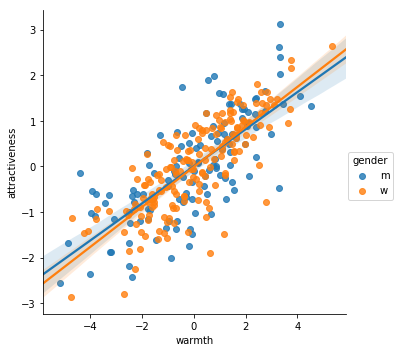

In [4]:
# scatter plot

sns.lmplot('warmth', 'attractiveness', data = scores, hue="gender")

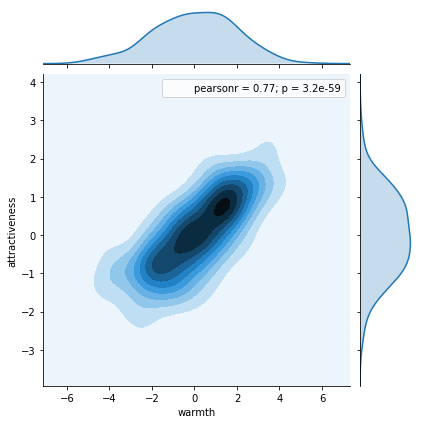

In [5]:
# histogram, kernel density estimation
sns.jointplot('warmth', 'attractiveness', data = scores, kind="kde").set_axis_labels("warmth", "attractiveness")

Get 3 clusters of speakers based on the WAAT distribution.
Each cluster with approx. the same number of instances.

mid     117
high    104
low      79
Name: class, dtype: int64


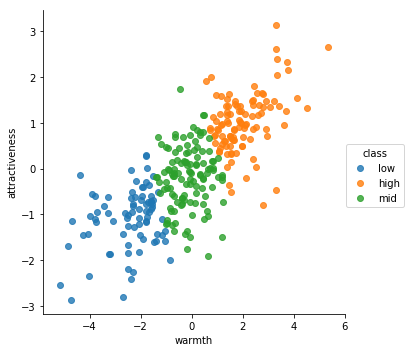

In [6]:
# applying k-means

n_clusters=3

kmeans = KMeans(n_clusters=n_clusters, random_state=2302).fit(scores[['warmth','attractiveness']])

scores['class'] = pd.Categorical(kmeans.labels_).rename_categories(['low','high','mid'])

sns.lmplot('warmth', 'attractiveness', data = scores, hue="class",fit_reg=False)
 
print(scores['class'].value_counts())    

## Select trait for binary classification and perform data partition

**Removing** speakers in the mid class to address binary classification.

In [7]:
# remove speakers in the mid class

scores = scores.loc[ scores['class'] != 'mid', ['spkID','gender','class']]

scores.head()


,spkID,gender,class
2,6,m,high
4,16,m,high
7,20,m,low
9,22,m,low
10,23,m,low


In [8]:
scores['class'] = pd.Categorical(scores['class'], categories=['low','high'])

print(scores.groupby(['gender','class']).count())

              spkID
gender class       
m      low       34
       high      46
w      low       45
       high      58


Split speakers into train (75%) and test (25%) speakers with class and gender balance (stratified) by creating the dummy "gendertrait" class.

In [9]:
# get stratified random partition for train and test

scores['genderclass']=scores[['gender', 'class']].apply(lambda x: ''.join(x), axis=1)

indexes = np.arange(0,len(scores))
classes = scores['class']
train_i, test_i, train_y, test_y = train_test_split(indexes, 
                                                    classes, 
                                                    test_size=0.25, 
                                                    stratify = scores['genderclass'], 
                                                    random_state=2302)

scores_train = scores.iloc[train_i,:] 
scores_test = scores.iloc[test_i,:] 

print('Number of speakers in Train:',len(scores_train))
print('Number of speakers in Test:',len(scores_test))

print('Number of w-high speakers in Train:', len(scores_train.loc[scores_train['genderclass']=='whigh']) )
print('Number of m-high speakers in Train:', len(scores_train.loc[scores_train['genderclass']=='mhigh']) )
print('Number of w-low speakers in Train:', len(scores_train.loc[scores_train['genderclass']=='wlow']) )
print('Number of m-high speakers in Train:', len(scores_train.loc[scores_train['genderclass']=='mlow']) )

print('Number of w-high speakers in Test:', len(scores_test.loc[scores_test['genderclass']=='whigh']) )
print('Number of m-high speakers in Test:', len(scores_test.loc[scores_test['genderclass']=='mhigh']) )
print('Number of w-low speakers in Test:', len(scores_test.loc[scores_test['genderclass']=='wlow']) )
print('Number of m-low speakers in Test:', len(scores_test.loc[scores_test['genderclass']=='mlow']) )


# # save these data for other evaluations
scores_train.iloc[:,0:3].to_csv(r'..\data\generated_data\speakerIDs_cls_WAAT_train.csv', index=False)
scores_test.iloc[:,0:3].to_csv(r'..\data\generated_data\speakerIDs_clss_WAAT_test.csv', index=False)

Number of speakers in Train: 137
Number of speakers in Test: 46
Number of w-high speakers in Train: 43
Number of m-high speakers in Train: 34
Number of w-low speakers in Train: 34
Number of m-high speakers in Train: 26
Number of w-high speakers in Test: 15
Number of m-high speakers in Test: 12
Number of w-low speakers in Test: 11
Number of m-low speakers in Test: 8


## Speech features

Speech features have been extracted from the semi-spontaneous dialogs uttered by the 300 speakers of the [NSC corpus](http://www.qu.tu-berlin.de/?id=nsc-corpus). 

Each semi-spontaneous dialog was splitted into 3 segments of approx. 20s, and the 88 [eGeMAPS](http://ieeexplore.ieee.org/document/7160715/) speech features were extracted from each segment (see ..\feature_extraction).

299 speakers recorded 4 semi-spontaneous dialogs, and 1 female speaker recorded 1 semi-spontaneous dialog. Total = 1197 dialogs * 3 segments = 3591 speech files.

Unfortunately, no subjective ratings have been collected for the spontaneous dialogs d5, d7, or d8. However, we use the speech features in order to have more instances with which to train and test the models.

**I assume** that the speakers' trait classes remain constant across recordings, that is, is a speaker is perceived as 'high' in the _intelligent_ trait for dialog 6 (d6, pizza dialog), then this perception would be the same for the other dialogs uttered by the same speaker.

In [10]:
# load speech features

path = "https://raw.githubusercontent.com/laufergall/ML_Speaker_Characteristics/master/data/extracted_features/"

url = path + "/eGeMAPSv01a_semispontaneous_splitted.csv"
s = requests.get(url).content
feats =pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ';') # shape: 3591, 89

feats.describe()

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
count,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,...,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000
mean,32.074811,0.164822,29.331234,32.116749,34.979195,5.647962,214.705528,295.668503,169.914992,275.787170,...,0.010479,0.013236,0.071767,2.886362,2.007963,0.221566,0.165240,0.284134,0.417329,-36.338693
std,5.328665,0.048619,5.607906,5.591671,5.569061,1.795868,125.960017,250.885566,127.855815,271.865651,...,0.021249,0.002613,0.026480,0.582544,0.352177,0.043843,0.043784,0.076922,0.088756,3.655192
min,18.653170,0.042523,15.820370,17.475750,21.539220,1.861065,-1.284895,8.829769,-88.358820,5.645364,...,-0.081376,-0.003725,0.024064,1.254826,1.003764,0.100800,0.045621,0.114545,0.109176,-49.664970
25%,26.739480,0.130898,23.757365,26.487690,29.599050,4.400768,123.712800,118.036100,79.464975,81.877190,...,-0.003275,0.011667,0.053619,2.456779,1.758794,0.190541,0.134932,0.229104,0.361183,-38.860995
50%,34.306000,0.156014,31.710540,34.792220,37.338260,5.419893,185.773900,210.748100,130.231600,164.244500,...,0.011492,0.013374,0.066551,2.835696,2.007528,0.217083,0.159807,0.276333,0.417081,-36.402810
75%,36.630120,0.191418,34.186190,36.802260,39.593045,6.535017,273.657000,393.345000,225.026900,383.648100,...,0.025134,0.015017,0.083654,3.264876,2.225413,0.246432,0.189568,0.330000,0.472313,-34.025370
max,41.767930,0.391718,39.079370,42.096060,45.941690,18.397280,942.694600,1651.011000,1074.595000,1698.962000,...,0.077525,0.021781,0.226448,5.505506,3.355705,0.411176,0.447600,0.695000,1.885223,-24.326250


Pre-processing features with the transformation **learnt with training data**:

* center and scale speech features

In [11]:
# Separate instances according to the train and test partition
# instances corresponding to speakers in the mid class will be left out

# extract speaker ID from speech file name
feats['spkID'] = feats['name'].str.slice(2, 5).astype('int')

# appending class label
feats_class_train = pd.merge(feats, scores_train[['spkID','genderclass','class']], how='inner')
feats_class_test = pd.merge(feats, scores_test[['spkID','genderclass','class']], how='inner')

print('Number of high instances in Train:', len(feats_class_train.loc[feats_class_train['class']=='high']) )
print('Number of low instances in Train:', len(feats_class_train.loc[feats_class_train['class']=='low']) )
print('Number of high instances in Test:', len(feats_class_test.loc[feats_class_test['class']=='high']) )
print('Number of low instances in Test:', len(feats_class_test.loc[feats_class_test['class']=='low']) )

feats_class_train.head()

Number of high instances in Train: 924
Number of low instances in Train: 720
Number of high instances in Test: 324
Number of low instances in Test: 228


,name,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,...,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,spkID,genderclass,class
0,'m006_rabat_d5_01.wav',31.23358,0.262306,26.59388,30.09026,34.11197,7.518097,316.59510,610.79350,267.6818,...,2.910414,2.643574,0.201035,0.209331,0.180400,0.286503,-30.14587,6,mhigh,high
1,'m006_rabat_d5_02.wav',31.31265,0.205003,27.27562,31.13765,34.80304,7.527420,90.15386,78.50047,223.4587,...,2.228286,1.550388,0.253529,0.187034,0.405807,0.462146,-30.21316,6,mhigh,high
2,'m006_rabat_d5_03.wav',32.08952,0.210413,27.79275,31.72719,35.72678,7.934029,277.98860,632.48160,139.8396,...,2.590194,2.132591,0.233043,0.190101,0.229767,0.381140,-29.06304,6,mhigh,high
3,'m006_rabat_d6_01.wav',32.86148,0.209119,28.24504,32.85449,37.06210,8.817057,299.96070,709.52120,171.5547,...,3.178340,1.770956,0.304667,0.248820,0.247241,0.419860,-27.91848,6,mhigh,high
4,'m006_rabat_d6_02.wav',31.04583,0.249890,26.29376,29.80590,33.76602,7.472261,191.92640,177.29000,113.4793,...,2.354326,1.890136,0.239687,0.185363,0.317407,0.477544,-29.62095,6,mhigh,high


In [12]:
# Standardize speech features  

# save feature names
feats_names = list(feats_class_train.drop(['name','spkID','genderclass','class'],axis=1))

myfile = open(r'.\data_while_tuning\feats_names.csv', 'w')
for item in feats_names:
    myfile.write("%r\n" % item)

# learn transformation on training data
scaler = StandardScaler()
scaler.fit(feats_class_train.drop(['name','spkID','genderclass','class'],axis=1))

# numpy n_instances x n_feats
feats_s_train = scaler.transform(feats_class_train.drop(['name','spkID','genderclass','class'],axis=1))
feats_s_test = scaler.transform(feats_class_test.drop(['name','spkID','genderclass','class'],axis=1)) 

## Model tuning with feature selection

Use the train data to find the classifier and its hyperparameters leading to the best performance. 

Perform feature selection with "SelectKBest": selecting best k features based on ANOVA F-value computed between class label and feature. k ranging from 2 to total number of features in intervals of 5.

In [169]:
"""
Summarize results of cross-validation on set A for hyperparameter tuning

Inputs:
- cname: classifier name
- grid_result: gridsearch results for this classifier, output of grid.fit(AX, Ay)  
- filename: filename with path to write the summary to
"""
def summary_tuning(cname, grid_result, filename):
    
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    # print best result and append to our lists
    print("%r -> Best cross-val score on A set: %f using %s" % (cname, grid_result.best_score_, grid_result.best_params_))
    
    # dataframe with summary    
    d = {
        'model': cname, 
        'mean_acc_A': means, 
        'stdev_acc_A': stds, 
        'params': params, 
    }
    df = pd.DataFrame(data = d) 
    df.to_csv(filename, index=False)
      
                           
        

"""
Perform nested hyperparameter tuning.
Given training data splitted into A, B sets and for each classifier type:
Stratified cross-validation for feature selection and hyperparameter tuning using set A
Generates csv file with summary of hp tuning (set A)
Evaluate the performance on set B and return accs

Input:
- AX and BX: features of the train set, splitted
- Ay and By: labels of the train set, splitted
- get_cls_functions: list of functions tho get classifier and dict of hp to tune

Output: 
- cls_acc_hps: pandas dataframe with:
    - classifiers names
    - classifiers hyperparameters
    - selected features
    - accuracies on B set
    of each tuned classifier corresponding to get_cls_functions
- trained_cls_list: list of classifiers tuned and trained on (AX+BX)
"""    

def hp_tuner(AX, BX, Ay, By, get_cls_functions):

    # init lists (there will be one element per classifier in get_cls_functions)
    
    classifiers_names = []
    classifiers = []
    hparam_grids = []
    best_accs = [] # on the B set
    best_hps = [] # determined with CV on A
    sel_feats_i = [] # indexes of selected features
    sel_feats = [] # names of selected features
    trained_cls_list = [] # tuned classifier trained on X,y
    
    # iterate over list of functions 
    # to get classifiers and parameters and append to our lists

    for fn in get_cls_functions:     
        clsname, cls, hp = fn()
        classifiers_names.append(clsname)
        classifiers.append(cls)
        hparam_grids.append(hp)
        
    # tune hyperparameters with GridSearchCV for each classifier
    
    for i in np.arange(len(classifiers)):

        # create pipeline
        pipe = Pipeline([
            ('selecter', SelectKBest(f_classif, k=4)),
            ('classifier', classifiers[i])
        ])
        
        # feature selection params
        fsel_params = dict(
            selecter__k = np.arange(2, AX.shape[1], 5)
        )

        # feature selection params and classifier's params for param_grid: 
        all_params = {**fsel_params, **hparam_grids[i]}
        
        # perform grid search
        grid = GridSearchCV(estimator=pipe,
                            param_grid=all_params,
                            scoring='recall_macro', # average per-class accuracy 
                            n_jobs=1,
                            cv=10)
        
        # This might take a while:
        grid_result = grid.fit(AX, Ay) 
        
        # summary of hp tuning on set A
        # generate one csv file per classifier
        summary_tuning(classifiers_names[i], 
                       grid_result, 
                       r'.\data_while_tuning\%s_tuning.csv' % classifiers_names[i])

        # get selected features on set A
        sel_i = grid_result.best_estimator_.named_steps['selecter'].get_support()
        selected = [i for indx, i in enumerate(feats_names) if sel_i[indx]]
        print("%r -> Selected features: %r" % (classifiers_names[i], selected))
        sel_feats_i.append(sel_i)
        sel_feats.append(selected)
        
        # evaluate classifier on set B
        By_pred = grid_result.best_estimator_.predict(BX)
        score_on_B = recall_score(By, By_pred, average='macro')
        print("%r -> Average per-class accuracy on B set: %f\n" % (classifiers_names[i], score_on_B))
        
        # add score on B and hyperparams for output
        best_accs.append(score_on_B)
        best_hps.append(grid_result.best_params_)
        
        # train classifier using all training data with this classifier
        X = np.concatenate((AX, BX), axis=0)
        y = np.concatenate((Ay, By), axis=0)
        trained_cls = grid_result.best_estimator_.fit(X,y)
        trained_cls_list.append(trained_cls)
    
    # create the output dataframe    
    d = {
        'classifiers_names': classifiers_names, 
        'best_accs': best_accs, 
        'best_hps': best_hps, 
        'sel_feats': sel_feats, 
        'sel_feats_i': sel_feats_i
    }
    cls_acc_hps = pd.DataFrame(data = d) 
    
    return cls_acc_hps, trained_cls_list

Main code snippet to evaluate classification accuracy:
    
* Choose data (feature and labels) for train X and y and test Xt and yt
* Split train data into A and B sets
* Hyperparameter tuner using A and B sets data by calling hp_tuner()
    * For each classifier type:
        * Stratified cross-validation for hyperparameter tuning using set A
        * Evaluate the performance on set B
* Select classifier based on the best performance on set B and train it using all training data   
* Get performance on test set

(Nested hyperparameter tuning inspired by [A. Zheng](http://www.oreilly.com/data/free/evaluating-machine-learning-models.csp))


In [14]:
# training data. Features and labels
X = feats_s_train
y = feats_class_train['class'].cat.codes

# test data. Features and labels
Xt = feats_s_test
yt = feats_class_test['class'].cat.codes

# split train data into 80% and 20% subsets - with balance in trait and gender
# give subset A to the inner hyperparameter tuner
# and hold out subset B for meta-evaluation
AX, BX, Ay, By = train_test_split(X, y, test_size=0.20, stratify = feats_class_train['genderclass'], random_state=2302)

print('Number of instances in A (hyperparameter tuning):',AX.shape[0])
print('Number of instances in B (meta-evaluation):',BX.shape[0])
    

Number of instances in A (hyperparameter tuning): 1315
Number of instances in B (meta-evaluation): 329


In [70]:
# dataframe with results from hp tuner to be appended
tuning_all = pd.DataFrame()

# list with tuned classifiers trained on training data, to be appended
trained_all = []

In [16]:
# save splits

import csv

# original features and class
feats_class_train.to_csv(r'.\data_while_tuning\feats_class_train.csv', index=False)
feats_class_test.to_csv(r'.\data_while_tuning\feats_class_test.csv', index=False)

# train/test partitions, features and labels
np.save(r'.\data_while_tuning\X.npy', X)
np.save(r'.\data_while_tuning\y.npy', y)
np.save(r'.\data_while_tuning\Xt.npy', Xt)
np.save(r'.\data_while_tuning\yt.npy', yt)

# # A/B splits, features and labels
np.save(r'.\data_while_tuning\AX.npy', AX)
np.save(r'.\data_while_tuning\BX.npy', BX)
np.save(r'.\data_while_tuning\Ay.npy', Ay)
np.save(r'.\data_while_tuning\By.npy', By)



In [17]:
"""
Saving outpus of hp tuning to disk
Called after tuning each classifier

Input:
- tuning_all: pandas df with tuning results
- trained_all: list of all classifiers trained on training data
""" 
def save_tuning(tuning_all, trained_all):
    
    # save tuning_all
    tuning_all.to_csv(r'.\data_while_tuning\tuning_all.csv', index=False)
    
    # save trained_all
    for i in np.arange(len(trained_all)):
        filename = r'.\data_while_tuning\trained_' + tuning_all.loc[i, 'classifiers_names'] + '.sav'
        pickle.dump(trained_all[i], open(filename, 'wb'))
        
"""
Loading outpus of hp tuning from disk
Called to recover what was tuned and trained in previous sessions

Output:
- tuning_all: pandas df with tuning results
- trained_all: list of all classifiers trained on training data
""" 
def load_tuning():
    
    # load tuning_all
    tuning_all = pd.read_csv(r'.\data_while_tuning\tuning_all.csv')
    
    # load trained_all
    trained_all=[]
    for i in np.arange(len(tuning_all)):
        filename = r'.\data_while_tuning\trained_' + tuning_all.loc[i, 'classifiers_names'] + '.sav'
        loaded_model = pickle.load(open(filename, 'rb'))
        trained_all.append(loaded_model)
        
    return tuning_all, trained_all

### Calling hp_tuner() for each classifier individually

** Recover ** when new ipynb session started
(Workaround for working with hyperparameter tuning during several days)

In [ ]:

# original features and class
feats_class_train = pd.read_csv(r'.\data_while_tuning\feats_class_train.csv')
feats_class_test = pd.read_csv(r'.\data_while_tuning\feats_class_test.csv')

# train/test partitions, features and labels
X = np.load(r'.\data_while_tuning\X.npy')
y = np.load(r'.\data_while_tuning\y.npy')
Xt = np.load(r'.\data_while_tuning\Xt.npy')
yt = np.load(r'.\data_while_tuning\yt.npy')

# # A/B splits, features and labels
AX = np.load(r'.\data_while_tuning\AX.npy')
BX = np.load(r'.\data_while_tuning\BX.npy')
Ay = np.load(r'.\data_while_tuning\Ay.npy')
By = np.load(r'.\data_while_tuning\By.npy')


In [69]:
# Loading outpus of hp tuning from disk
tuning_all, trained_all = load_tuning()

Call this after each experiment: 

In [46]:
# save tuning_all (.csv) and trained_all (nameclassifier.sav)
save_tuning(tuning_all, trained_all)

#### GaussianNB

*class sklearn.naive_bayes.GaussianNB(priors=None)*

No parameters to tune for this classifier. Priors not specified, so they will be adjusted given the data.

In [95]:
from sklearn.naive_bayes import GaussianNB

"""
Naive Bayes Classifier
"""
def get_GaussianNB2tune():

    model = GaussianNB()
    hp = dict()
    return 'GaussianNB', model, hp

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, [get_GaussianNB2tune])

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'GaussianNB' -> Best cross-val score on A set: 0.685354 using {'selecter': SelectKBest(k=37, score_func=<function f_classif at 0x000001C8DECC10D0>), 'selecter__k': 37}
'GaussianNB' -> Selected features: ['F0semitoneFrom27.5Hz_sma3nz_stddevNorm', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2', 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_stddevRisingSlope', 'spectralFlux_sma3_stddevNorm', 'mfcc4_sma3_amean', 'jitterLocal_sma3nz_amean', 'jitterLocal_sma3nz_stddevNorm', 'shimmerLocaldB_sma3nz_amean', 'shimmerLocaldB_sma3nz_stddevNorm', 'HNRdBACF_sma3nz_stddevNorm', 'logRelF0-H1-A3_sma3nz_amean', 'logRelF0-H1-A3_sma3nz_stddevNorm', 'F1frequency_sma3nz_amean', 'F1frequency_sma3nz_stddevNorm', 'F2frequency_sma3nz_amean', 'F2bandwidth_sma3nz_stddevNorm', 'F3frequency_sma3nz_amean', 'F3frequency_sma3nz_stddevNorm', 'F3bandwidth_sma3nz_amean', 'alphaRatioV_sma3nz_stddevNorm', 'hammarber

0    {'selecter': SelectKBest(k=37, score_func=<fun...
1    {'selecter': SelectKBest(k=37, score_func=<fun...
2    {'selecter': SelectKBest(k=37, score_func=<fun...
3    {'selecter': SelectKBest(k=37, score_func=<fun...
4    {'selecter': SelectKBest(k=37, score_func=<fun...
Name: params, dtype: object


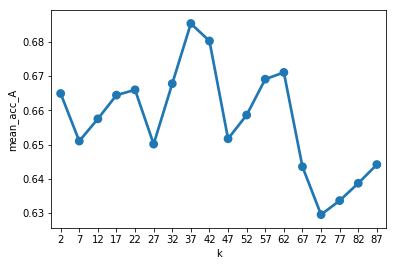

In [155]:
# open generated file with results of fitting GridSearchCV
 
sgrid = pd.read_csv(r'.\data_while_tuning\GaussianNB_tuning.csv')
print(sgrid['params'].head())

# get number of k from each row
params_splitted = sgrid['params'].str.split(':')
sgrid['k'] = params_splitted.apply(lambda x: int(x[-1][1:-1]))

# plot acc vs. k
sns.pointplot(x='k', y='mean_acc_A', data=sgrid) # hue

#### LogisticRegression

*class sklearn.linear_model.LogisticRegression(penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver=’liblinear’, max_iter=100, multi_class=’ovr’, verbose=0, warm_start=False, n_jobs=1)*

Tuning C (inverse of regularization strength). The 'liblinear' solver (a good choice for small datasets) handles L1 penalty.


In [170]:
from sklearn.linear_model import LogisticRegression

"""
Logistic Regression
"""
def get_LogisticRegression2tune():

    model = LogisticRegression()
    hp = dict(
        #classifier__penalty = ['l1','l2'],
        classifier__C = np.logspace(-3,3,num=7)
    )
    return 'LogisticRegression', model, hp

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, [get_LogisticRegression2tune])

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'LogisticRegression' -> Best cross-val score on A set: 0.756037 using {'classifier__C': 10.0, 'selecter__k': 87}
'LogisticRegression' -> Selected features: ['F0semitoneFrom27.5Hz_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2', 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0', 'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0', 'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope', 'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope', 'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean', 'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean', 'mfcc1_sma3_stdde

Including more features is beneficial for the performance of logistic regression. Similar behavior for C >=0.1

   classifier__C  selecter__k
0          0.001          2.0
1          0.001          7.0
2          0.001         12.0
3          0.001         17.0
4          0.001         22.0


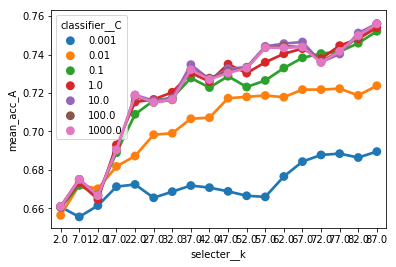

In [198]:
# open generated file with results of fitting GridSearchCV
 
sgrid = pd.read_csv(r'.\data_while_tuning\LogisticRegression_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__C', data=sgrid.join(params_df)) # 

#### K Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

"""
K Nearest Neighbors
"""
def get_KNeighborsClassifier2tune():

    model = KNeighborsClassifier()
    hp = dict(
        classifier__n_neighbors = list(range(1,50))
    )
    return 'KNeighborsClassifier', model, hp

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, [get_KNeighborsClassifier2tune])

# # update lists of tuning info and trained classifiers
# tuning_all = tuning_all.append(tuning, ignore_index=True)
# trained_all.append(trained)

#### Support Vector Machines

In [ ]:
from sklearn.svm import SVC

"""
Support Vector Machines
"""
def get_SVC2tune():
    
    model = SVC()
    hp = dict(
        classifier__C = np.logspace(-5,3,num=9),
        classifier__kernel = ['poly'], #['linear', 'poly', 'rbf', 'sigmoid'],
        classifier__degree = [2] #, # only 'poly' kernel
        #classifier__gamma = np.logspace(-5,3,num=9)
    )
    return 'SVC', model, hp

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, [get_SVC2tune])

# # update lists of tuning info and trained classifiers
# tuning_all = tuning_all.append(tuning, ignore_index=True)
# trained_all.append(trained)

#### DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

"""
Decision Trees
"""
def get_DecisionTreeClassifier2tune():
    
    model = DecisionTreeClassifier()
    hp = dict(
        classifier__max_depth = np.arange(2,4)#np.arange(2,11)
    )
    return 'DecisionTreeClassifier', model, hp

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, [get_DecisionTreeClassifier2tune])

# # update lists of tuning info and trained classifiers
# tuning_all = tuning_all.append(tuning, ignore_index=True)
# trained_all.append(trained)

#### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

"""
Random Forest
"""
def get_RandomForestClassifier2tune():
    
    model = RandomForestClassifier()
    hp = dict(
        classifier__n_estimators = np.arange(2,4)#np.arange(2,51)
    )
    return 'RandomForestClassifier', model, hp

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, [get_RandomForestClassifier2tune])

# # update lists of tuning info and trained classifiers
# tuning_all = tuning_all.append(tuning, ignore_index=True)
# trained_all.append(trained)

In [ ]:
# select the classifier that gave the maximum acc on B set
best_accs = tuning_all['best_accs']
i_best = best_accs.idxmax()

print('Selected classifier based on the best performance on B: %r (accB = %0.2f)' % (tuning_all.loc[i_best,'classifiers_names'], round(best_accs[i_best],2)))

In [ ]:
# predictions on the test set 
# feat sel on Xt is performed by the classifier
yt_pred = trained_all[i_best][0].predict(Xt)

score_on_test = recall_score(yt, yt_pred, average='macro')

print("Average per-class accuracy on test: %f" % score_on_test) 

cm = confusion_matrix(yt, yt_pred)
print(classification_report(yt, yt_pred, digits = 2))
print(cm)
 